MAIN CODE

In [ ]:
"""
LatentGPT Training Script (RAM-efficient, with YarnLogger)
----------------------------------------------------------
- Uses memmap dataset (e.g., wikipedia_tokens.bin)
- Gradient accumulation + mixed precision
- Logs train/val loss, perplexity, learning rate
- Saves best model automatically
- Saves metrics CSV and plots at the end
"""

import os, json, time, math, csv
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from contextlib import nullcontext
import pandas as pd
import matplotlib.pyplot as plt

# ==================== CONFIG ====================

MEMMAP_BIN_PATH = "/kaggle/input/bin-stp/wikipedia_tokens.bin"
MEMMAP_META_PATH = "/kaggle/input/data-stp/wikipedia_tokens_meta.json"

# Model hyperparameters
n_embd = 512
n_head = 8
n_layer = 6
dropout = 0.1

# Training hyperparameters
batch_size = 8
block_size = 512
learning_rate = 6e-4
weight_decay = 0.1
grad_clip = 1.0
max_iters = 90000
eval_interval = 500
eval_iters = 50
warmup_iters = 1000
gradient_accumulation_steps = 2
use_amp = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


with open(MEMMAP_META_PATH, "r") as f:
    meta = json.load(f)

tokens_mem = np.memmap(MEMMAP_BIN_PATH, dtype=np.int32, mode="r")
n_tokens = tokens_mem.shape[0]

# auto-detect vocab size from data
max_token_id = int(tokens_mem.max())
meta_vocab = meta.get("vocab_size", None)

if meta_vocab is None or meta_vocab <= max_token_id:
    vocab_size = max_token_id + 1
    print(f"⚠ Auto-adjusted vocab_size to {vocab_size} (max token ID found: {max_token_id})")
else:
    vocab_size = meta_vocab

# optionally check meta n_tokens
meta_n_tokens = meta.get("n_tokens", meta.get("length", None))
if meta_n_tokens is not None and meta_n_tokens != n_tokens:
    print(f"⚠ Warning: meta tokens mismatch (meta={meta_n_tokens}, actual={n_tokens})")

split_idx = int(0.9 * n_tokens)
train_data = tokens_mem[:split_idx]
val_data = tokens_mem[split_idx:]

print(f"Total tokens: {n_tokens:,} | Train: {len(train_data):,} | Val: {len(val_data):,} | Vocab: {vocab_size}")

# ==================== BATCH FUNCTION ====================

def get_batch(split):
    data = train_data if split=="train" else val_data
    ix = torch.randint(0, len(data)-block_size-1, (batch_size,))
    x = torch.empty((batch_size, block_size), dtype=torch.long)
    y = torch.empty((batch_size, block_size), dtype=torch.long)
    for i in range(batch_size):
        start = int(ix[i])
        chunk = data[start:start+block_size+1].astype(np.int64)
        x[i] = torch.from_numpy(chunk[:-1])
        y[i] = torch.from_numpy(chunk[1:])
    return x.to(device), y.to(device)

# ==================== MODEL ====================

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        rms = x.norm(dim=-1, keepdim=True) * (1.0 / math.sqrt(x.shape[-1]))
        return self.weight * (x / (rms + self.eps))

class LatentAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_dim = n_embd // n_head
        self.c_attn = nn.Linear(n_embd, 3*n_embd)
        self.c_proj = nn.Linear(n_embd, n_embd)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        mask = torch.tril(torch.ones(block_size, block_size)).view(1,1,block_size,block_size)
        self.register_buffer("mask", mask)
    def forward(self, x):
        B,T,C = x.size()
        q,k,v = self.c_attn(x).split(C, dim=2)
        q = q.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        k = k.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        v = v.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        att = (q @ k.transpose(-2,-1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:,:,:T,:T]==0,float("-inf"))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.transpose(1,2).contiguous().view(B,T,C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        self.ln1 = RMSNorm(n_embd)
        self.ln2 = RMSNorm(n_embd)
        self.attn = LatentAttention(n_embd, n_head, dropout, block_size)
        self.ff = FeedForward(n_embd, dropout)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

class LatentGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([TransformerBlock(n_embd,n_head,dropout,block_size) for _ in range(n_layer)])
        self.ln_f = RMSNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        self.apply(self._init_weights)
    def _init_weights(self,module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight,0.0,0.02)
            if module.bias is not None: nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight,0.0,0.02)
    def forward(self, idx, targets=None):
        B,T = idx.shape
        if T > block_size: raise ValueError(f"Sequence length {T} > block_size {block_size}")
        pos = torch.arange(0,T,device=idx.device).unsqueeze(0)
        x = self.drop(self.tok_emb(idx)+self.pos_emb(pos))
        for block in self.blocks: x = block(x)
        logits = self.lm_head(self.ln_f(x))
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1,vocab_size), targets.view(-1), ignore_index=-1)
        return logits, loss

class YarnLogger:
    def __init__(self, log_dir, run_name=None, project=None, enable_wandb=False):
        self.log_dir = Path(log_dir); self.log_dir.mkdir(parents=True,exist_ok=True)
        self.csv_path = self.log_dir/"yarn_logs.csv"
        self.rows = []; self.fields=None
        self.run_name = run_name or f"yarn_{int(time.time())}"
        self.enable_wandb=enable_wandb; self.wandb=None
        if enable_wandb:
            try: import wandb; self.wandb=wandb; wandb.init(project=project or "latentgpt", name=self.run_name)
            except: self.wandb=None
    def log(self, step=None, **metrics):
        record={"step":step} if step is not None else {}
        record.update(metrics); self.rows.append(record)
        if self.fields is None:
            self.fields=list(record.keys())
            with open(self.csv_path,"w",newline="") as f: csv.DictWriter(f,fieldnames=self.fields).writeheader(); csv.DictWriter(f,fieldnames=self.fields).writerow(record)
        else:
            with open(self.csv_path,"a",newline="") as f: csv.DictWriter(f,fieldnames=self.fields).writerow(record)
        if self.wandb: self.wandb.log({k:v for k,v in record.items() if k!="step"}, step=step)
    def save_checkpoint(self,path,meta=None):
        meta_path=Path(path).with_suffix(".yarnmeta.json"); meta_data=meta or {}; meta_data.update({"saved_at":time.time(),"path":str(path)})
        with open(meta_path,"w") as f: json.dump(meta_data,f,indent=2)
    def close(self):
        if self.wandb:
            try: self.wandb.finish()
            except: pass


def get_lr(iter_):
    if iter_ < warmup_iters: return learning_rate * iter_/warmup_iters
    decay_ratio = (iter_-warmup_iters)/(max_iters-warmup_iters)
    coeff = 0.5*(1+math.cos(math.pi*decay_ratio))
    return learning_rate*0.1 + coeff*(learning_rate - learning_rate*0.1)

@torch.no_grad()
def estimate_loss(model, eval_iters, device):
    model.eval(); losses={"train":[], "val":[]}
    ctx = torch.cuda.amp.autocast if (use_amp and device.type=="cuda") else nullcontext
    for split in ["train","val"]:
        for _ in range(eval_iters):
            xb,yb=get_batch(split)
            with ctx(): _,loss=model(xb,yb)
            losses[split].append(loss.item())
    model.train()
    return {"train":sum(losses["train"])/len(losses["train"]),
            "val":sum(losses["val"])/len(losses["val"])}


model = LatentGPT().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type=="cuda") else None
ctx = torch.cuda.amp.autocast if (use_amp and device.type=="cuda") else nullcontext

dirs={"checkpoints":"/kaggle/working/checkpoints","logs":"/kaggle/working/logs","plots":"/kaggle/working/plots"}
for path in dirs.values(): os.makedirs(path, exist_ok=True)

yarn = YarnLogger(log_dir=dirs["logs"], run_name="latentgpt_run", enable_wandb=False)


best_val_loss = float("inf")
metrics={"train_losses":[], "val_losses":[], "perplexities":[], "learning_rates":[], "iterations":[], "timestamps":[]}
start_time = time.time()

try:
    for step in range(max_iters):
        lr = get_lr(step)
        for pg in optimizer.param_groups: pg["lr"]=lr

                 # Eval
        if step % eval_interval==0 or step==max_iters-1:
            losses=estimate_loss(model, eval_iters, device)
            train_loss,val_loss=losses["train"],losses["val"]
            ppl = float(math.exp(val_loss))
            metrics["train_losses"].append(train_loss)
            metrics["val_losses"].append(val_loss)
            metrics["perplexities"].append(ppl)
            metrics["learning_rates"].append(lr)
            metrics["iterations"].append(step)
            metrics["timestamps"].append(time.time()-start_time)
            print(f"[Step {step}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | PPL: {ppl:.2f} | LR: {lr:.2e}")
            yarn.log(step=step, train_loss=train_loss, val_loss=val_loss, perplexity=ppl, lr=lr)

            if val_loss < best_val_loss:
                best_val_loss=val_loss
                ckpt_path = os.path.join(dirs["checkpoints"],"best_model.pt")
                torch.save({"step":step,"model_state_dict":model.state_dict(),"optimizer_state_dict":optimizer.state_dict(),"val_loss":val_loss}, ckpt_path)
                yarn.save_checkpoint(ckpt_path, meta={"val_loss":float(val_loss),"step":int(step)})
                print(f"✅ Saved BEST model at step {step}")

# Train
        optimizer.zero_grad(set_to_none=True)
        for _ in range(gradient_accumulation_steps):
            xb,yb=get_batch("train")
            with ctx(): _,loss=model(xb,yb)
            loss = loss/gradient_accumulation_steps
            if scaler: scaler.scale(loss).backward()
            else: loss.backward()
        if scaler:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
            optimizer.step()

finally:
    total_time=time.time()-start_time
    print(f"\n✅ Training finished in {total_time/3600:.2f} hours")

  # Save CSV
    df=pd.DataFrame({
        "iteration":metrics["iterations"],
        "train_loss":metrics["train_losses"],
        "val_loss":metrics["val_losses"],
        "perplexity":metrics["perplexities"],
        "learning_rate":metrics["learning_rates"],
        "time_sec":metrics["timestamps"]
    })
    csv_path=os.path.join(dirs["logs"],"training_metrics.csv")
    df.to_csv(csv_path,index=False)
    print(f"✅ Metrics saved to {csv_path}")

    fig,axes=plt.subplots(2,2,figsize=(16,12))
    axes[0,0].plot(metrics["iterations"], metrics["train_losses"], label="Train")
    axes[0,0].plot(metrics["iterations"], metrics["val_losses"], label="Val")
    axes[0,0].set_title("Loss"); axes[0,0].legend(); axes[0,0].grid(True,alpha=0.3)
    axes[0,1].plot(metrics["iterations"], metrics["perplexities"]); axes[0,1].set_title("Perplexity"); axes[0,1].grid(True,alpha=0.3)
    axes[1,0].plot(metrics["iterations"], metrics["learning_rates"]); axes[1,0].set_title("Learning Rate"); axes[1,0].set_yscale("log"); axes[1,0].grid(True,alpha=0.3)
    axes[1,1].plot([t/3600 for t in metrics["timestamps"]], metrics["val_losses"]); axes[1,1].set_title("Val Loss vs Time"); axes[1,1].grid(True,alpha=0.3)
    plt.tight_layout()
    plot_path=os.path.join(dirs["plots"],"training_results.png")
    plt.savefig(plot_path,dpi=300,bbox_inches="tight")
    print(f"✅ Saved plot to {plot_path}")

    yarn.close()
    print("\nDone. Check checkpoints, logs, and plots.")


TEXT OUTPUT CODE

In [ ]:
import torch
import math
import json
import sentencepiece as spm

# ==================== PATHS ====================
checkpoint_path = "/kaggle/input/model-pt/best_model (2).pt"
meta_path = "/kaggle/input/model-json-1/wikipedia_tokens_meta.json"
spm_model_path = "/kaggle/input/data-stp/spm_tokenizer.model"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==================== MODEL COMPONENTS ====================
class RMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.ones(dim))
    def forward(self, x):
        rms = x.norm(dim=-1, keepdim=True) * (1.0 / math.sqrt(x.shape[-1]))
        return self.weight * (x / (rms + self.eps))

class LatentAttention(torch.nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_dim = n_embd // n_head
        self.c_attn = torch.nn.Linear(n_embd, 3*n_embd)
        self.c_proj = torch.nn.Linear(n_embd, n_embd)
        self.attn_dropout = torch.nn.Dropout(dropout)
        self.resid_dropout = torch.nn.Dropout(dropout)
        mask = torch.tril(torch.ones(block_size, block_size)).view(1,1,block_size,block_size)
        self.register_buffer("mask", mask)
    def forward(self, x):
        B,T,C = x.size()
        q,k,v = self.c_attn(x).split(C, dim=2)
        q = q.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        k = k.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        v = v.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        att = (q @ k.transpose(-2,-1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:,:,:T,:T]==0,float("-inf"))
        att = torch.nn.functional.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.transpose(1,2).contiguous().view(B,T,C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(torch.nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_embd, 4*n_embd),
            torch.nn.GELU(),
            torch.nn.Linear(4*n_embd, n_embd),
            torch.nn.Dropout(dropout)
        )
    def forward(self, x): return self.net(x)

class TransformerBlock(torch.nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        self.ln1 = RMSNorm(n_embd)
        self.ln2 = RMSNorm(n_embd)
        self.attn = LatentAttention(n_embd, n_head, dropout, block_size)
        self.ff = FeedForward(n_embd, dropout)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

class LatentGPT(torch.nn.Module):
    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, dropout):
        super().__init__()
        self.tok_emb = torch.nn.Embedding(vocab_size, n_embd)
        self.pos_emb = torch.nn.Embedding(block_size, n_embd)
        self.drop = torch.nn.Dropout(dropout)
        self.blocks = torch.nn.ModuleList([TransformerBlock(n_embd,n_head,dropout,block_size) for _ in range(n_layer)])
        self.ln_f = RMSNorm(n_embd)
        self.lm_head = torch.nn.Linear(n_embd, vocab_size, bias=False)
    def forward(self, idx, targets=None):
        B,T = idx.shape
        pos = torch.arange(0,T,device=idx.device).unsqueeze(0)
        x = self.drop(self.tok_emb(idx)+self.pos_emb(pos))
        for block in self.blocks: x = block(x)
        logits = self.lm_head(self.ln_f(x))
        loss = None
        if targets is not None:
            loss = torch.nn.functional.cross_entropy(logits.view(-1,logits.size(-1)), targets.view(-1), ignore_index=-1)
        return logits, loss

# ==================== LOAD METADATA AND CHECKPOINT ====================
with open(meta_path, "r") as f:
    meta = json.load(f)

checkpoint = torch.load(checkpoint_path, map_location=device)
vocab_size = checkpoint["model_state_dict"]["tok_emb.weight"].shape[0]

# Hyperparameters (must match training)
n_embd = 512
n_head = 8
n_layer = 6
block_size = 512
dropout = 0.1

# ==================== LOAD MODEL ====================
model = LatentGPT(vocab_size, n_embd, n_head, n_layer, block_size, dropout).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
print("✅ Model loaded successfully")

# ==================== LOAD TOKENIZER ====================
sp = spm.SentencePieceProcessor()
sp.load(spm_model_path)

# ==================== TEXT GENERATION ====================
def generate_text(model, sp, prompt="", max_len=100, temperature=1.0):
    # Encode prompt to token IDs
    if prompt:
        input_ids = sp.encode(prompt, out_type=int)
    else:
        input_ids = [0]  # default start token
    idx = torch.tensor([input_ids], dtype=torch.long).to(device)
    for _ in range(max_len):
        with torch.no_grad():
            logits, _ = model(idx)
        logits = logits[:, -1, :] / temperature
        probs = torch.nn.functional.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)
    # Decode token IDs to text
    output_ids = idx[0].cpu().numpy().tolist()
    return sp.decode(output_ids)

# ==================== GENERATE EXAMPLE ====================
prompt = "She"
generated_text = generate_text(model, sp, prompt=prompt, max_len=100, temperature=1.0)
print("=== Generated Text ===")
print(generated_text)


TOKENIZER AND ALL TESTED CODE ARE BELOW

In [ ]:
# !pip install transformers datasets tokenizers accelerate


In [ ]:
# import re

# input_file = "/kaggle/input/merge-wiki/merged_wikipedia.txt"
# output_file = "english_cleaned.txt"

# # Working emoji regex for Kaggle
# EMOJI_REGEX = re.compile(
#     "[" 
#     "\U0001F600-\U0001F64F"
#     "\U0001F300-\U0001F5FF"
#     "\U0001F680-\U0001F6FF"
#     "\U0001F1E0-\U0001F1FF"
#     "\U00002700-\U000027BF"
#     "\U0001F900-\U0001F9FF"
#     "\U0001FA70-\U0001FAFF"
#     "\U00002600-\U000026FF"
#     "]+",
#     flags=re.UNICODE
# )

# def is_english_simple(text, threshold=0.7):
#     english_chars = re.findall(r"[A-Za-z0-9 .,!?;:'\"()\[\]{}\-_/]", text)
#     ratio = len(english_chars) / max(1, len(text))
#     return ratio >= threshold

# with open(input_file, "r", encoding="utf-8", errors="ignore") as fin, \
#      open(output_file, "w", encoding="utf-8") as fout:

#     for line in fin:
#         line = line.strip()

#         # 1. Remove emojis
#         line = EMOJI_REGEX.sub("", line)

#         # 2. Remove URLs
#         line = re.sub(r"http\S+|www.\S+", "", line)

#         # 3. Remove other-language chars, keep punctuation + numbers
#         line = re.sub(r"[^A-Za-z0-9 .,!?;:'\"()\[\]{}\-_/]", " ", line)

#         # 4. Fix spacing
#         line = re.sub(r"\s+", " ", line).strip()

#         # 5. Keep even tiny lines
#         # (no length filtering)

#         # 6. English ratio filter
#         if not is_english_simple(line):
#             continue

#         fout.write(line + "\n")

# print("Cleaning Done → Saved to english_cleaned.txt")


In [ ]:
# from tokenizers import Tokenizer, trainers, models, pre_tokenizers, processors
# from tokenizers.normalizers import NFD, StripAccents, Lowercase, Sequence
# from tokenizers.pre_tokenizers import Whitespace
# import os

# data_file = "/kaggle/working/english_cleaned.txt"

# tokenizer = Tokenizer(models.BPE())
# tokenizer.normalizer = Sequence([NFD(), Lowercase(), StripAccents()])
# tokenizer.pre_tokenizer = Whitespace()

# trainer = trainers.BpeTrainer(
#     vocab_size=50257,
#     min_frequency=2,
#     special_tokens=["<pad>", "<bos>", "<eos>", "<unk>"]
# )

# tokenizer.train([data_file], trainer)

# os.makedirs("tokenizer", exist_ok=True)
# tokenizer.save("tokenizer/tokenizer.json")


In [ ]:
# import numpy as np
# from tokenizers import Tokenizer
# import os, json, tqdm

# input_path = "/kaggle/working/english_cleaned.txt"
# tok = Tokenizer.from_file("/kaggle/working/tokenizer/tokenizer.json")

# # Count tokens
# total_tokens = 0
# with open(input_path, "r", encoding="utf-8") as f:
#     for line in f:
#         total_tokens += len(tok.encode(line).ids)

# # Create memmap
# arr = np.memmap("train.bin", dtype=np.uint16, mode="w+", shape=(total_tokens,))
# idx = 0

# with open(input_path, "r", encoding="utf8") as f:
#     for line in tqdm.tqdm(f):
#         ids = tok.encode(line).ids
#         arr[idx:idx+len(ids)] = ids
#         idx += len(ids)

# arr.flush()

# with open("meta.json", "w") as f:
#     json.dump({"vocab_size": tok.get_vocab_size()}, f)


In [ ]:
# import math
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from transformers import PreTrainedTokenizerFast

# # ============================================================
# #  ROTARY POSITIONAL EMBEDDINGS (RoPE) + YARN Scaling
# # ============================================================

# def apply_rope(x, sin, cos):
#     x1 = x[..., ::2]
#     x2 = x[..., 1::2]
#     return torch.cat([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)

# def yarn_scale_frequencies(angles, orig_max, new_max, alpha=1.0):
#     if new_max == orig_max:
#         return angles
#     return angles * ((new_max / orig_max) ** alpha)

# def build_rope_cache_yarn(seq_len, head_dim, device, orig_max=2048, new_max=8192, alpha=1.0):
#     theta = 10000 ** (torch.arange(0, head_dim, 2, device=device) / head_dim)
#     pos = torch.arange(0, seq_len, device=device).unsqueeze(1)
#     angles = yarn_scale_frequencies(pos / theta, orig_max, new_max, alpha)
#     sin, cos = angles.sin(), angles.cos()
#     return sin, cos

# # ============================================================
# #  Multi-head GQA Attention
# # ============================================================

# class MultiHeadAttn(nn.Module):
#     def __init__(self, d_model, n_query_heads=8, n_kv_heads=2):
#         super().__init__()
#         self.n_q = n_query_heads
#         self.n_kv = n_kv_heads
#         self.head_dim = d_model // n_query_heads

#         self.Wq = nn.Linear(d_model, d_model)
#         self.Wk = nn.Linear(d_model, n_kv_heads * self.head_dim)
#         self.Wv = nn.Linear(d_model, n_kv_heads * self.head_dim)
#         self.out = nn.Linear(d_model, d_model)

#     def forward(self, x, rope_cache):
#         B, T, C = x.shape
#         sin, cos = rope_cache

#         q = self.Wq(x).view(B, T, self.n_q, self.head_dim).transpose(1, 2)
#         k = self.Wk(x).view(B, T, self.n_kv, self.head_dim).transpose(1, 2)
#         v = self.Wv(x).view(B, T, self.n_kv, self.head_dim).transpose(1, 2)

#         q = apply_rope(q, sin, cos)
#         k = apply_rope(k, sin, cos)

#         if self.n_kv != self.n_q:
#             repeat_factor = self.n_q // self.n_kv
#             k = k.repeat_interleave(repeat_factor, dim=1)
#             v = v.repeat_interleave(repeat_factor, dim=1)

#         scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
#         mask = torch.triu(torch.ones(T, T, device=x.device), 1)
#         scores = scores.masked_fill(mask == 1, float('-inf'))
#         att = torch.softmax(scores, dim=-1)

#         out = (att @ v).transpose(1, 2).contiguous().view(B, T, C)
#         return self.out(out)

# # ============================================================
# #  FeedForward Network
# # ============================================================

# class FeedForward(nn.Module):
#     def __init__(self, d_model, d_ff):
#         super().__init__()
#         self.fc1 = nn.Linear(d_model, d_ff)
#         self.fc2 = nn.Linear(d_ff, d_model)

#     def forward(self, x):
#         return self.fc2(F.gelu(self.fc1(x)))

# # ============================================================
# #  Transformer Block
# # ============================================================

# class GPTBlock(nn.Module):
#     def __init__(self, d_model, n_q_heads, n_kv_heads, d_ff):
#         super().__init__()
#         self.attn = MultiHeadAttn(d_model, n_q_heads, n_kv_heads)
#         self.ff = FeedForward(d_model, d_ff)
#         self.ln1 = nn.LayerNorm(d_model)
#         self.ln2 = nn.LayerNorm(d_model)

#     def forward(self, x, rope_cache):
#         x = x + self.attn(self.ln1(x), rope_cache)
#         x = x + self.ff(self.ln2(x))
#         return x

# # ============================================================
# #  Full GPT Model
# # ============================================================

# class GPT2(nn.Module):
#     def __init__(self, vocab_size, n_layers=8, n_q_heads=8, n_kv_heads=2,
#                  d_model=512, d_ff=2048, max_seq=8192, rope_orig=2048, yarn_alpha=1.0):
#         super().__init__()
#         self.tok_emb = nn.Embedding(vocab_size, d_model)
#         self.layers = nn.ModuleList([GPTBlock(d_model, n_q_heads, n_kv_heads, d_ff)
#                                      for _ in range(n_layers)])
#         self.ln_f = nn.LayerNorm(d_model)
#         self.head = nn.Linear(d_model, vocab_size, bias=False)

#         sin, cos = build_rope_cache_yarn(
#             seq_len=max_seq, head_dim=d_model // n_q_heads, device="cpu",
#             orig_max=rope_orig, new_max=max_seq, alpha=yarn_alpha
#         )
#         self.register_buffer("rope_sin", sin)
#         self.register_buffer("rope_cos", cos)

#     def forward(self, x):
#         B, T = x.shape
#         tok = self.tok_emb(x)
#         rope_cache = (self.rope_sin[:T].to(x.device), self.rope_cos[:T].to(x.device))
#         h = tok
#         for layer in self.layers:
#             h = layer(h, rope_cache)
#         h = self.ln_f(h)
#         return self.head(h)

# # ============================================================
# #  Memory-mapped Dataset (RAM-safe)
# # ============================================================

# class MemmapDataset(Dataset):
#     def __init__(self, memmap_path, block_size):
#         self.data = np.memmap(memmap_path, dtype=np.uint16, mode="r")
#         self.block_size = block_size
#         self.len = len(self.data)

#     def __len__(self):
#         return self.len - self.block_size - 1

#     def __getitem__(self, idx):
#         x = torch.tensor(self.data[idx:idx+self.block_size], dtype=torch.long)
#         y = torch.tensor(self.data[idx+1:idx+self.block_size+1], dtype=torch.long)
#         return x, y

# def create_dataloaders(bin_path, block_size=512, batch_size=4, split=0.9):
#     data = np.memmap(bin_path, dtype=np.uint16, mode="r")
#     cutoff = int(len(data) * split)
#     train_ds = MemmapDataset(bin_path, block_size)
#     val_ds = MemmapDataset(bin_path, block_size)
#     return DataLoader(train_ds, batch_size=batch_size, shuffle=True), \
#            DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# # ============================================================
# #  Perplexity Evaluation
# # ============================================================

# def evaluate_perplexity(model, loader, vocab_size, device):
#     model.eval()
#     losses = []
#     with torch.no_grad():
#         for x, y in loader:
#             x, y = x.to(device), y.to(device)
#             logits = model(x)
#             loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))
#             losses.append(loss.item())
#     mean_loss = sum(losses) / len(losses)
#     ppl = math.exp(mean_loss)
#     return mean_loss, ppl

# # ============================================================
# #  Training Loop (RAM-safe)
# # ============================================================

# def train_model(model, train_loader, val_loader, vocab_size, epochs=3, lr=3e-4, device="cuda"):
#     optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

#     for epoch in range(epochs):
#         model.train()
#         for step, (x, y) in enumerate(train_loader):
#             x, y = x.to(device), y.to(device)
#             logits = model(x)
#             loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             if step % 50 == 0:
#                 print(f"[Epoch {epoch}] Step {step} Train Loss {loss.item():.4f}")

#         val_loss, val_ppl = evaluate_perplexity(model, val_loader, vocab_size, device)
#         print(f"Epoch {epoch} | Val Loss {val_loss:.4f} | Val PPL {val_ppl:.2f}")
#         torch.save(model.state_dict(), "latest_model.pt")

# # ============================================================
# #  Text Generation (RAM-safe)
# # ============================================================

# def generate(model, tokenizer, prompt, max_new_tokens=100, temperature=1.0, top_k=40, device="cuda"):
#     model.eval()
#     tokens = tokenizer.encode(prompt).ids
#     x = torch.tensor(tokens, dtype=torch.long, device=device).unsqueeze(0)

#     for _ in range(max_new_tokens):
#         logits = model(x)
#         logits = logits[:, -1, :] / temperature
#         if top_k:
#             values, _ = torch.topk(logits, top_k)
#             logits = logits.masked_fill(logits < values[:, [-1]], -float("inf"))
#         probs = torch.softmax(logits, dim=-1)
#         next_tok = torch.multinomial(probs, num_samples=1)
#         x = torch.cat([x, next_tok], dim=1)

#     return tokenizer.decode(x[0].tolist())

# # ============================================================
# #  MAIN
# # ============================================================

# if __name__ == "__main__":
#     # Load tokenizer
#     tokenizer = PreTrainedTokenizerFast(tokenizer_file="/kaggle/input/token-en/tokenizer (4).json")
#     vocab_size = tokenizer.vocab_size
#     print("Vocab size:", vocab_size)

#     # Memory-mapped data
#     bin_path = "/kaggle/input/trian-en-vs/train.bin"
#     train_loader, val_loader = create_dataloaders(bin_path, block_size=512, batch_size=4, split=0.9)

#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     model = GPT2(vocab_size=vocab_size, n_layers=8, n_q_heads=8, n_kv_heads=2,
#                  d_model=512, d_ff=2048, max_seq=8192).to(device)

#     # Train
#     train_model(model, train_loader, val_loader, vocab_size, epochs=3, lr=3e-4, device=device)

#     # Generate
#     print(generate(model, tokenizer, "Once upon a time", max_new_tokens=100))


In [ ]:
# import psutil
# print("Fresh RAM:", psutil.virtual_memory().percent)


In [ ]:
# import os
# import math
# import time
# import json
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from contextlib import nullcontext

# # ============================================================
# # CONFIG
# # ============================================================

# MEMMAP_BIN_PATH = "/kaggle/input/trian-en-vs/train.bin"
# MEMMAP_META_PATH = "/kaggle/input/trian-en-vs/meta.json"

# block_size = 512
# batch_size = 4
# device = "cuda" if torch.cuda.is_available() else "cpu"
# epochs = 3
# lr = 3e-4
# gradient_accumulation_steps = 2
# eval_interval = 500

# # Model hyperparameters
# n_layers = 8
# n_q_heads = 8
# n_kv_heads = 2
# d_model = 512
# d_ff = 2048
# max_seq = 8192
# rope_orig = 2048
# yarn_alpha = 1.0
# dropout = 0.1

# # Checkpoint/log directories
# dirs = {
#     "checkpoints": "./checkpoints",
#     "logs": "./logs",
# }
# for path in dirs.values():
#     os.makedirs(path, exist_ok=True)

# # ============================================================
# # LOAD MEMMAP DATA
# # ============================================================

# with open(MEMMAP_META_PATH, "r") as f:
#     meta = json.load(f)
# vocab_size = meta["vocab_size"]

# tokens_mem = np.memmap(MEMMAP_BIN_PATH, dtype=np.uint16, mode="r")
# n_tokens = len(tokens_mem)
# split_idx = int(0.9 * n_tokens)
# train_data = tokens_mem[:split_idx]
# val_data = tokens_mem[split_idx:]

# print(f"Total tokens: {n_tokens}, Train: {len(train_data)}, Val: {len(val_data)}, Vocab: {vocab_size}")

# # ============================================================
# # BATCH FUNCTION (MEMMAP-SAFE)
# # ============================================================

# def get_batch(split):
#     data = train_data if split == "train" else val_data
#     ix = torch.randint(0, len(data) - block_size - 1, (batch_size,))
#     x = torch.empty((batch_size, block_size), dtype=torch.long)
#     y = torch.empty((batch_size, block_size), dtype=torch.long)
#     for i in range(batch_size):
#         start = int(ix[i])
#         chunk = data[start:start + block_size + 1].astype(np.int64)
#         x[i] = torch.from_numpy(chunk[:-1])
#         y[i] = torch.from_numpy(chunk[1:])
#     return x.to(device), y.to(device)

# # ============================================================
# # ROPE + YARN
# # ============================================================

# def apply_rope(x, sin, cos):
#     x1 = x[..., ::2]
#     x2 = x[..., 1::2]
#     return torch.cat([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)

# def yarn_scale(angles, orig_max, new_max, alpha=1.0):
#     if new_max == orig_max:
#         return angles
#     return angles * ((new_max / orig_max) ** alpha)

# def build_rope_cache(seq_len, head_dim, device, orig_max=rope_orig, new_max=max_seq, alpha=yarn_alpha):
#     theta = 10000 ** (torch.arange(0, head_dim, 2, device=device) / head_dim)
#     pos = torch.arange(0, seq_len, device=device).unsqueeze(1)
#     angles = yarn_scale(pos / theta, orig_max, new_max, alpha)
#     sin, cos = angles.sin(), angles.cos()
#     return sin, cos

# # ============================================================
# # MODEL WITH GQA
# # ============================================================

# class GQA_Attention(nn.Module):
#     def __init__(self, d_model, n_q_heads, n_kv_heads, dropout=0.1):
#         super().__init__()
#         self.n_q = n_q_heads
#         self.n_kv = n_kv_heads
#         self.head_dim = d_model // n_q_heads

#         self.Wq = nn.Linear(d_model, d_model)
#         self.Wk = nn.Linear(d_model, n_kv_heads * self.head_dim)
#         self.Wv = nn.Linear(d_model, n_kv_heads * self.head_dim)
#         self.out = nn.Linear(d_model, d_model)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x, rope_cache):
#         B, T, C = x.shape
#         sin, cos = rope_cache
#         q = self.Wq(x).view(B, T, self.n_q, self.head_dim).transpose(1, 2)
#         k = self.Wk(x).view(B, T, self.n_kv, self.head_dim).transpose(1, 2)
#         v = self.Wv(x).view(B, T, self.n_kv, self.head_dim).transpose(1, 2)
#         q = apply_rope(q, sin, cos)
#         k = apply_rope(k, sin, cos)

#         if self.n_kv != self.n_q:
#             repeat_factor = self.n_q // self.n_kv
#             k = k.repeat_interleave(repeat_factor, dim=1)
#             v = v.repeat_interleave(repeat_factor, dim=1)

#         scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
#         mask = torch.triu(torch.ones(T, T, device=x.device), 1)
#         scores = scores.masked_fill(mask == 1, float("-inf"))
#         attn = torch.softmax(scores, dim=-1)
#         out = (attn @ v).transpose(1, 2).contiguous().view(B, T, C)
#         return self.out(out)

# class FeedForward(nn.Module):
#     def __init__(self, d_model, d_ff, dropout=0.1):
#         super().__init__()
#         self.fc1 = nn.Linear(d_model, d_ff)
#         self.fc2 = nn.Linear(d_ff, d_model)
#         self.drop = nn.Dropout(dropout)
#     def forward(self, x):
#         return self.drop(self.fc2(F.gelu(self.fc1(x))))

# class GPTBlock(nn.Module):
#     def __init__(self, d_model, n_q_heads, n_kv_heads, d_ff, dropout=0.1):
#         super().__init__()
#         self.attn = GQA_Attention(d_model, n_q_heads, n_kv_heads, dropout)
#         self.ff = FeedForward(d_model, d_ff, dropout)
#         self.ln1 = nn.LayerNorm(d_model)
#         self.ln2 = nn.LayerNorm(d_model)
#     def forward(self, x, rope_cache):
#         x = x + self.attn(self.ln1(x), rope_cache)
#         x = x + self.ff(self.ln2(x))
#         return x

# class GPT2_GQA(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.tok_emb = nn.Embedding(vocab_size, d_model)
#         self.layers = nn.ModuleList([GPTBlock(d_model, n_q_heads, n_kv_heads, d_ff, dropout) for _ in range(n_layers)])
#         self.ln_f = nn.LayerNorm(d_model)
#         self.head = nn.Linear(d_model, vocab_size, bias=False)
#         sin, cos = build_rope_cache(max_seq, d_model // n_q_heads, device="cpu")
#         self.register_buffer("rope_sin", sin)
#         self.register_buffer("rope_cos", cos)

#     def forward(self, x):
#         B, T = x.shape
#         h = self.tok_emb(x)
#         rope_cache = (self.rope_sin[:T].to(x.device), self.rope_cos[:T].to(x.device))
#         for layer in self.layers:
#             h = layer(h, rope_cache)
#         h = self.ln_f(h)
#         return self.head(h)

# # ============================================================
# # TRAINING LOOP WITH CHECKPOINTING
# # ============================================================

# model = GPT2_GQA().to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# scaler = torch.cuda.amp.GradScaler() if device == "cuda" else None
# ctx = torch.cuda.amp.autocast if device == "cuda" else nullcontext

# metrics = {"train_loss": [], "val_loss": []}
# best_val_loss = float("inf")
# start_time = time.time()

# for epoch in range(epochs):
#     model.train()
#     step = 0
#     while True:
#         try:
#             x, y = get_batch("train")
#         except IndexError:
#             break

#         with ctx():
#             logits = model(x)
#             loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))
#             loss = loss / gradient_accumulation_steps

#         optimizer.zero_grad(set_to_none=True)
#         if scaler:
#             scaler.scale(loss).backward()
#         else:
#             loss.backward()

#         if (step + 1) % gradient_accumulation_steps == 0:
#             if scaler:
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#                 optimizer.step()
#         if step % 50 == 0:
#             print(f"[Epoch {epoch}] Step {step} | Train Loss: {loss.item()*gradient_accumulation_steps:.4f}")
#         step += 1
#         if step >= len(train_data) // block_size:
#             break

#     # ============ VALIDATION ============
#     model.eval()
#     val_losses = []
#     with torch.no_grad():
#         for _ in range(100):
#             xb, yb = get_batch("val")
#             logits = model(xb)
#             loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
#             val_losses.append(loss.item())
#     mean_val_loss = sum(val_losses) / len(val_losses)
#     metrics["train_loss"].append(loss.item()*gradient_accumulation_steps)
#     metrics["val_loss"].append(mean_val_loss)
#     print(f"Epoch {epoch} | Validation Loss: {mean_val_loss:.4f} | PPL: {math.exp(mean_val_loss):.2f}")

#     # ============ SAVE CHECKPOINT ============
#     if mean_val_loss < best_val_loss:
#         best_val_loss = mean_val_loss
#         torch.save({
#             "epoch": epoch,
#             "model_state_dict": model.state_dict(),
#             "optimizer_state_dict": optimizer.state_dict(),
#             "val_loss": mean_val_loss,
#         }, os.path.join(dirs["checkpoints"], "best_model.pt"))
#         print(f"✅ Checkpoint saved at epoch {epoch} | Val Loss {mean_val_loss:.4f}")


In [ ]:
# import sentencepiece as spm

# input_file = "/kaggle/input/trian-en-vs/english_cleaned.txt"

# spm.SentencePieceTrainer.train(
#     input=input_file,
#     model_prefix="spm_tokenizer",
#     vocab_size=50000,
#     model_type="unigram",
#     character_coverage=1.0,

#     # RAM SAFE SETTINGS (Compatible with all SP versions)
#     train_extremely_large_corpus=True,
#     input_sentence_size=2000000,
#     shuffle_input_sentence=True,
# )

# print("Tokenizer trained successfully!")


In [ ]:
# import sentencepiece as spm

# sp = spm.SentencePieceProcessor()
# sp.load("spm_tokenizer.model")  # your trained tokenizer


In [ ]:
# import numpy as np
# from tqdm import tqdm

# input_file = "/kaggle/input/trian-en-vs/english_cleaned.txt"
# output_bin = "wikipedia_tokens.bin"

# # First, count total tokens to preallocate memmap
# total_tokens = 0
# with open(input_file, "r", encoding="utf-8") as f:
#     for line in f:
#         tokens = sp.encode(line.strip(), out_type=int)
#         total_tokens += len(tokens)

# print(f"Total tokens: {total_tokens}")

# # Create memmap
# tokens_memmap = np.memmap(output_bin, dtype=np.int32, mode="w+", shape=(total_tokens,))

# # Fill memmap
# idx = 0
# with open(input_file, "r", encoding="utf-8") as f:
#     for line in tqdm(f, total=None, desc="Encoding lines"):
#         tokens = sp.encode(line.strip(), out_type=int)
#         tokens_memmap[idx : idx + len(tokens)] = tokens
#         idx += len(tokens)

# tokens_memmap.flush()
# print("Saved memmap:", output_bin)


In [ ]:
# import json

# meta = {
#     "n_tokens": total_tokens,
#     "dtype": "int32",
#     "vocab_size": sp.get_piece_size(),
#     "tokenizer": "sentencepiece_unigram",
#     "block_size_recommendation": 512
# }

# with open("wikipedia_tokens_meta.json", "w") as f:
#     json.dump(meta, f, indent=2)

# print("Saved metadata")


In [ ]:
# """
# LatentGPT Training Script (RAM-efficient, with YarnLogger)
# ----------------------------------------------------------
# - Uses memmap dataset (e.g., wikipedia_tokens.bin)
# - Gradient accumulation + mixed precision
# - Logs train/val loss, perplexity, learning rate
# - Saves best model automatically
# - Saves metrics CSV and plots at the end
# """

# import os, json, time, math, csv
# from pathlib import Path
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.nn import functional as F
# from contextlib import nullcontext
# import pandas as pd
# import matplotlib.pyplot as plt

# # ==================== CONFIG ====================

# MEMMAP_BIN_PATH = "/kaggle/working/wikipedia_tokens.bin"
# MEMMAP_META_PATH = "/kaggle/working/wikipedia_tokens_meta.json"

# # Model hyperparameters
# n_embd = 512
# n_head = 8
# n_layer = 6
# dropout = 0.1

# # Training hyperparameters
# batch_size = 8
# block_size = 512
# learning_rate = 6e-4
# weight_decay = 0.1
# grad_clip = 1.0
# max_iters = 5000
# eval_interval = 500
# eval_iters = 50
# warmup_iters = 1000
# gradient_accumulation_steps = 2
# use_amp = True

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # ==================== LOAD MEMMAP ====================

# with open(MEMMAP_META_PATH, "r") as f:
#     meta = json.load(f)

# tokens_mem = np.memmap(MEMMAP_BIN_PATH, dtype=np.int32, mode="r")
# n_tokens = tokens_mem.shape[0]
# assert n_tokens == meta["n_tokens"], "Meta n_tokens mismatch!"

# split_idx = int(0.9 * n_tokens)
# train_data = tokens_mem[:split_idx]
# val_data = tokens_mem[split_idx:]
# vocab_size = meta.get("vocab_size", 50257)

# print(f"Total tokens: {n_tokens:,} | Train: {len(train_data):,} | Val: {len(val_data):,} | Vocab: {vocab_size}")

# # ==================== BATCH FUNCTION ====================

# def get_batch(split):
#     data = train_data if split=="train" else val_data
#     ix = torch.randint(0, len(data)-block_size-1, (batch_size,))
#     x = torch.empty((batch_size, block_size), dtype=torch.long)
#     y = torch.empty((batch_size, block_size), dtype=torch.long)
#     for i in range(batch_size):
#         start = int(ix[i])
#         chunk = data[start:start+block_size+1].astype(np.int64)
#         x[i] = torch.from_numpy(chunk[:-1])
#         y[i] = torch.from_numpy(chunk[1:])
#     return x.to(device), y.to(device)

# # ==================== MODEL ====================

# class RMSNorm(nn.Module):
#     def __init__(self, dim, eps=1e-5):
#         super().__init__()
#         self.eps = eps
#         self.weight = nn.Parameter(torch.ones(dim))
#     def forward(self, x):
#         rms = x.norm(dim=-1, keepdim=True) * (1.0 / math.sqrt(x.shape[-1]))
#         return self.weight * (x / (rms + self.eps))

# class LatentAttention(nn.Module):
#     def __init__(self, n_embd, n_head, dropout, block_size):
#         super().__init__()
#         assert n_embd % n_head == 0
#         self.n_head = n_head
#         self.head_dim = n_embd // n_head
#         self.c_attn = nn.Linear(n_embd, 3*n_embd)
#         self.c_proj = nn.Linear(n_embd, n_embd)
#         self.attn_dropout = nn.Dropout(dropout)
#         self.resid_dropout = nn.Dropout(dropout)
#         mask = torch.tril(torch.ones(block_size, block_size)).view(1,1,block_size,block_size)
#         self.register_buffer("mask", mask)
#     def forward(self, x):
#         B,T,C = x.size()
#         q,k,v = self.c_attn(x).split(C, dim=2)
#         q = q.view(B,T,self.n_head,self.head_dim).transpose(1,2)
#         k = k.view(B,T,self.n_head,self.head_dim).transpose(1,2)
#         v = v.view(B,T,self.n_head,self.head_dim).transpose(1,2)
#         att = (q @ k.transpose(-2,-1)) / math.sqrt(self.head_dim)
#         att = att.masked_fill(self.mask[:,:,:T,:T]==0,float("-inf"))
#         att = F.softmax(att, dim=-1)
#         att = self.attn_dropout(att)
#         y = att @ v
#         y = y.transpose(1,2).contiguous().view(B,T,C)
#         y = self.resid_dropout(self.c_proj(y))
#         return y

# class FeedForward(nn.Module):
#     def __init__(self, n_embd, dropout):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(n_embd, 4*n_embd),
#             nn.GELU(),
#             nn.Linear(4*n_embd, n_embd),
#             nn.Dropout(dropout)
#         )
#     def forward(self, x):
#         return self.net(x)

# class TransformerBlock(nn.Module):
#     def __init__(self, n_embd, n_head, dropout, block_size):
#         super().__init__()
#         self.ln1 = RMSNorm(n_embd)
#         self.ln2 = RMSNorm(n_embd)
#         self.attn = LatentAttention(n_embd, n_head, dropout, block_size)
#         self.ff = FeedForward(n_embd, dropout)
#     def forward(self, x):
#         x = x + self.attn(self.ln1(x))
#         x = x + self.ff(self.ln2(x))
#         return x

# class LatentGPT(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.tok_emb = nn.Embedding(vocab_size, n_embd)
#         self.pos_emb = nn.Embedding(block_size, n_embd)
#         self.drop = nn.Dropout(dropout)
#         self.blocks = nn.ModuleList([TransformerBlock(n_embd,n_head,dropout,block_size) for _ in range(n_layer)])
#         self.ln_f = RMSNorm(n_embd)
#         self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
#         self.apply(self._init_weights)
#     def _init_weights(self,module):
#         if isinstance(module, nn.Linear):
#             nn.init.normal_(module.weight,0.0,0.02)
#             if module.bias is not None: nn.init.zeros_(module.bias)
#         elif isinstance(module, nn.Embedding):
#             nn.init.normal_(module.weight,0.0,0.02)
#     def forward(self, idx, targets=None):
#         B,T = idx.shape
#         if T > block_size: raise ValueError(f"Sequence length {T} > block_size {block_size}")
#         pos = torch.arange(0,T,device=idx.device).unsqueeze(0)
#         x = self.drop(self.tok_emb(idx)+self.pos_emb(pos))
#         for block in self.blocks: x = block(x)
#         logits = self.lm_head(self.ln_f(x))
#         loss = None
#         if targets is not None:
#             loss = F.cross_entropy(logits.view(-1,vocab_size), targets.view(-1), ignore_index=-1)
#         return logits, loss

# # ==================== YARN LOGGER ====================

# class YarnLogger:
#     def __init__(self, log_dir, run_name=None, project=None, enable_wandb=False):
#         self.log_dir = Path(log_dir); self.log_dir.mkdir(parents=True,exist_ok=True)
#         self.csv_path = self.log_dir/"yarn_logs.csv"
#         self.rows = []; self.fields=None
#         self.run_name = run_name or f"yarn_{int(time.time())}"
#         self.enable_wandb=enable_wandb; self.wandb=None
#         if enable_wandb:
#             try: import wandb; self.wandb=wandb; wandb.init(project=project or "latentgpt", name=self.run_name)
#             except: self.wandb=None
#     def log(self, step=None, **metrics):
#         record={"step":step} if step is not None else {}
#         record.update(metrics); self.rows.append(record)
#         if self.fields is None:
#             self.fields=list(record.keys())
#             with open(self.csv_path,"w",newline="") as f: csv.DictWriter(f,fieldnames=self.fields).writeheader(); csv.DictWriter(f,fieldnames=self.fields).writerow(record)
#         else:
#             with open(self.csv_path,"a",newline="") as f: csv.DictWriter(f,fieldnames=self.fields).writerow(record)
#         if self.wandb: self.wandb.log({k:v for k,v in record.items() if k!="step"}, step=step)
#     def save_checkpoint(self,path,meta=None):
#         meta_path=Path(path).with_suffix(".yarnmeta.json"); meta_data=meta or {}; meta_data.update({"saved_at":time.time(),"path":str(path)})
#         with open(meta_path,"w") as f: json.dump(meta_data,f,indent=2)
#     def close(self):
#         if self.wandb:
#             try: self.wandb.finish()
#             except: pass

# # ==================== HELPERS ====================

# def get_lr(iter_):
#     if iter_ < warmup_iters: return learning_rate * iter_/warmup_iters
#     decay_ratio = (iter_-warmup_iters)/(max_iters-warmup_iters)
#     coeff = 0.5*(1+math.cos(math.pi*decay_ratio))
#     return learning_rate*0.1 + coeff*(learning_rate - learning_rate*0.1)

# @torch.no_grad()
# def estimate_loss(model, eval_iters, device):
#     model.eval(); losses={"train":[], "val":[]}
#     ctx = torch.cuda.amp.autocast if (use_amp and device.type=="cuda") else nullcontext
#     for split in ["train","val"]:
#         for _ in range(eval_iters):
#             xb,yb=get_batch(split)
#             with ctx(): _,loss=model(xb,yb)
#             losses[split].append(loss.item())
#     model.train()
#     return {"train":sum(losses["train"])/len(losses["train"]),
#             "val":sum(losses["val"])/len(losses["val"])}

# # ==================== INIT ====================

# model = LatentGPT().to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type=="cuda") else None
# ctx = torch.cuda.amp.autocast if (use_amp and device.type=="cuda") else nullcontext

# dirs={"checkpoints":"/kaggle/working/checkpoints","logs":"/kaggle/working/logs","plots":"/kaggle/working/plots"}
# for path in dirs.values(): os.makedirs(path, exist_ok=True)

# yarn = YarnLogger(log_dir=dirs["logs"], run_name="latentgpt_run", enable_wandb=False)

# # ==================== TRAINING LOOP ====================

# best_val_loss = float("inf")
# metrics={"train_losses":[], "val_losses":[], "perplexities":[], "learning_rates":[], "iterations":[], "timestamps":[]}
# start_time = time.time()

# try:
#     for step in range(max_iters):
#         lr = get_lr(step)
#         for pg in optimizer.param_groups: pg["lr"]=lr

#         # Evaluation
#         if step % eval_interval==0 or step==max_iters-1:
#             losses=estimate_loss(model, eval_iters, device)
#             train_loss,val_loss=losses["train"],losses["val"]
#             ppl = float(math.exp(val_loss))
#             metrics["train_losses"].append(train_loss)
#             metrics["val_losses"].append(val_loss)
#             metrics["perplexities"].append(ppl)
#             metrics["learning_rates"].append(lr)
#             metrics["iterations"].append(step)
#             metrics["timestamps"].append(time.time()-start_time)
#             print(f"[Step {step}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | PPL: {ppl:.2f} | LR: {lr:.2e}")
#             yarn.log(step=step, train_loss=train_loss, val_loss=val_loss, perplexity=ppl, lr=lr)

#             if val_loss < best_val_loss:
#                 best_val_loss=val_loss
#                 ckpt_path = os.path.join(dirs["checkpoints"],"best_model.pt")
#                 torch.save({"step":step,"model_state_dict":model.state_dict(),"optimizer_state_dict":optimizer.state_dict(),"val_loss":val_loss}, ckpt_path)
#                 yarn.save_checkpoint(ckpt_path, meta={"val_loss":float(val_loss),"step":int(step)})
#                 print(f"✅ Saved BEST model at step {step}")

#         # Training step
#         optimizer.zero_grad(set_to_none=True)
#         for _ in range(gradient_accumulation_steps):
#             xb,yb=get_batch("train")
#             with ctx(): _,loss=model(xb,yb)
#             loss = loss/gradient_accumulation_steps
#             if scaler: scaler.scale(loss).backward()
#             else: loss.backward()
#         if scaler:
#             scaler.unscale_(optimizer)
#             torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
#             scaler.step(optimizer)
#             scaler.update()
#         else:
#             torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
#             optimizer.step()

# finally:
#     total_time=time.time()-start_time
#     print(f"\n✅ Training finished in {total_time/3600:.2f} hours")

#     # Save metrics CSV
#     df=pd.DataFrame({
#         "iteration":metrics["iterations"],
#         "train_loss":metrics["train_losses"],
#         "val_loss":metrics["val_losses"],
#         "perplexity":metrics["perplexities"],
#         "learning_rate":metrics["learning_rates"],
#         "time_sec":metrics["timestamps"]
#     })
#     csv_path=os.path.join(dirs["logs"],"training_metrics.csv")
#     df.to_csv(csv_path,index=False)
#     print(f"✅ Metrics saved to {csv_path}")

#     # Plot results
#     fig,axes=plt.subplots(2,2,figsize=(16,12))
#     axes[0,0].plot(metrics["iterations"], metrics["train_losses"], label="Train")
#     axes[0,0].plot(metrics["iterations"], metrics["val_losses"], label="Val")
#     axes[0,0].set_title("Loss"); axes[0,0].legend(); axes[0,0].grid(True,alpha=0.3)
#     axes[0,1].plot(metrics["iterations"], metrics["perplexities"]); axes[0,1].set_title("Perplexity"); axes[0,1].grid(True,alpha=0.3)
#     axes[1,0].plot(metrics["iterations"], metrics["learning_rates"]); axes[1,0].set_title("Learning Rate"); axes[1,0].set_yscale("log"); axes[1,0].grid(True,alpha=0.3)
#     axes[1,1].plot([t/3600 for t in metrics["timestamps"]], metrics["val_losses"]); axes[1,1].set_title("Val Loss vs Time"); axes[1,1].grid(True,alpha=0.3)
#     plt.tight_layout()
#     plot_path=os.path.join(dirs["plots"],"training_results.png")
#     plt.savefig(plot_path,dpi=300,bbox_inches="tight")
#     print(f"✅ Saved plot to {plot_path}")

#     yarn.close()
#     print("\nDone. Check checkpoints, logs, and plots.")


Using device: cuda
Total tokens: 1,118,517,240 | Train: 1,006,665,516 | Val: 111,851,724 | Vocab: 50000


/tmp/ipykernel_47/455889352.py:235: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (use_amp and device.type=="cuda") else None
/tmp/ipykernel_47/455889352.py:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx(): _,loss=model(xb,yb)


[Step 0] Train Loss: 10.9275 | Val Loss: 10.9286 | PPL: 55750.53 | LR: 0.00e+00
✅ Saved BEST model at step 0


/tmp/ipykernel_47/455889352.py:279: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with ctx(): _,loss=model(xb,yb)


[Step 500] Train Loss: 6.5114 | Val Loss: 6.5943 | PPL: 730.91 | LR: 3.00e-04
✅ Saved BEST model at step 500
[Step 999] Train Loss: 6.0657 | Val Loss: 6.1646 | PPL: 475.62 | LR: 5.99e-04
✅ Saved BEST model at step 999

✅ Training finished in 0.13 hours
✅ Metrics saved to /kaggle/working/logs/training_metrics.csv
✅ Saved plot to /kaggle/working/plots/training_results.png

Done. Check checkpoints, logs, and plots.


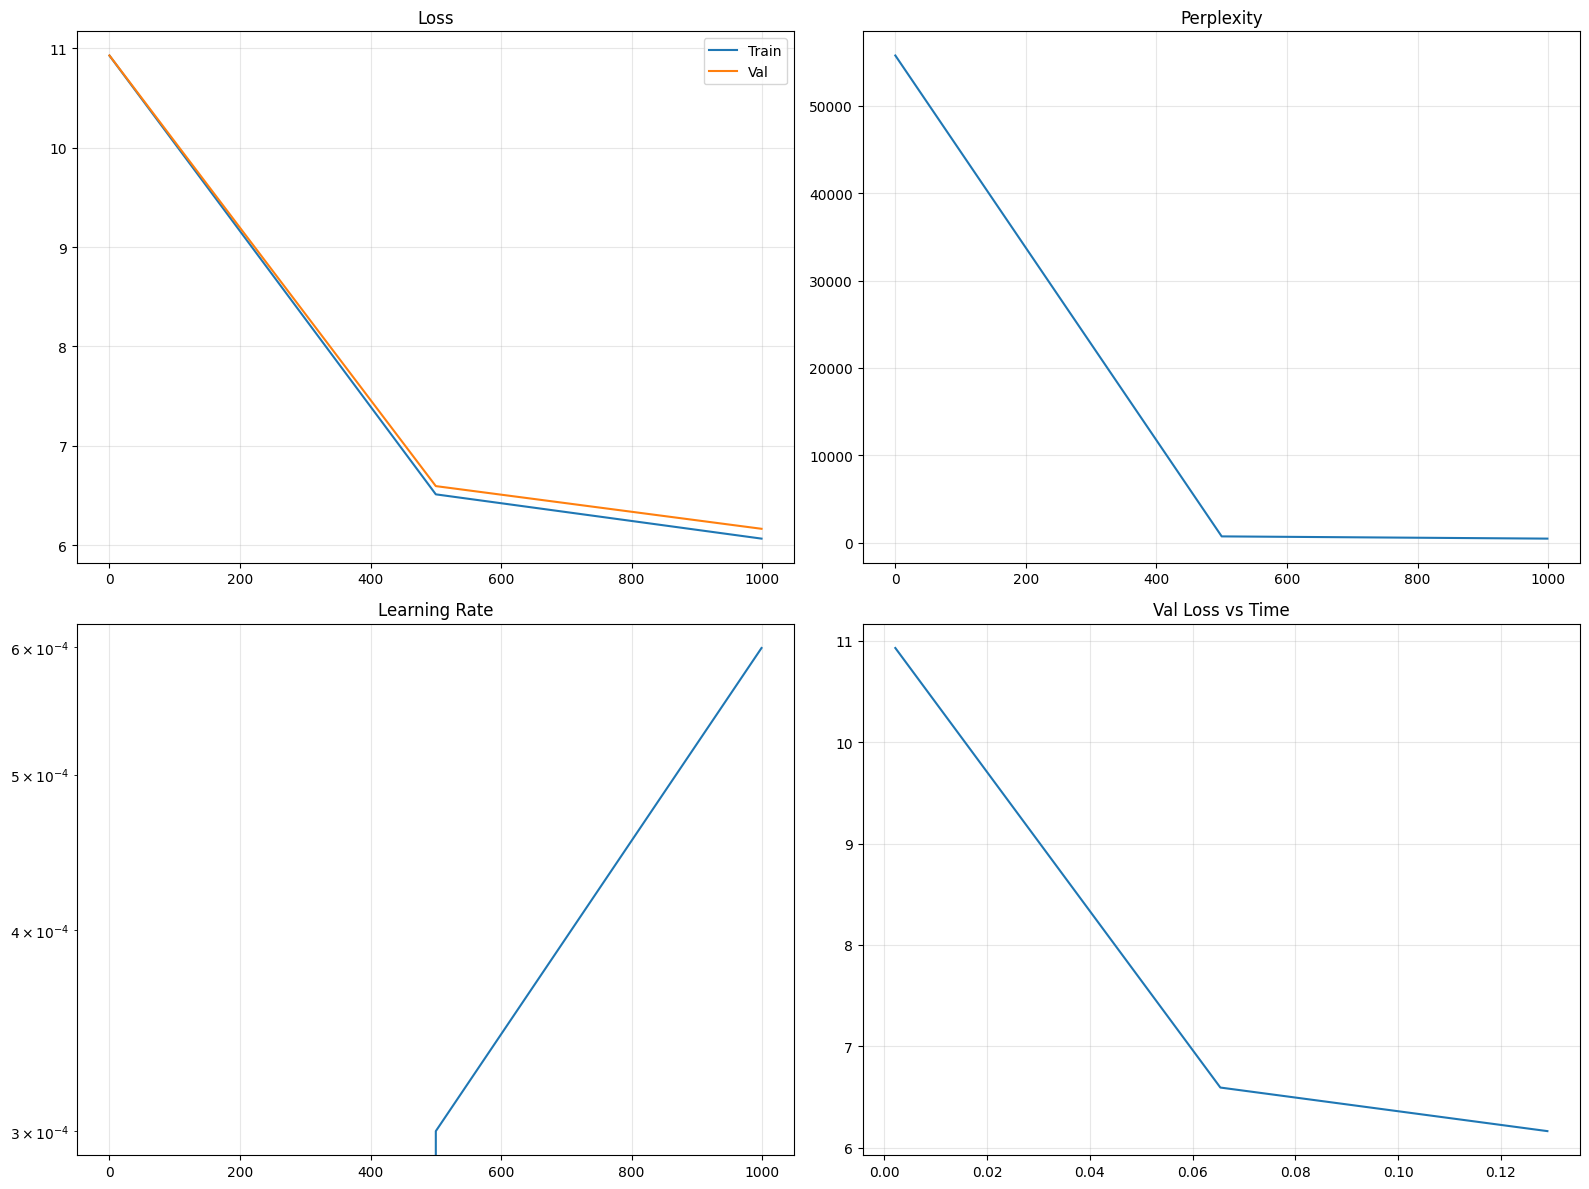

In [2]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load("/kaggle/input/model-final/spm_tokenizer (1).model")  # your tokenizer model
text = sp.decode_ids(generated_ids)
print(text)


NameError: name 'generated_ids' is not defined

In [3]:
import torch
import numpy as np

# ==================== CONFIG ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = "/kaggle/input/data-stp/spm_tokenizer.model"
num_tokens_to_generate = 100
start_token = 0  # starting token ID

# ==================== LOAD MODEL ====================
model = LatentGPT().to(device)
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# ==================== GENERATION FUNCTION ====================
@torch.no_grad()
def generate_tokens(model, start_tokens, max_new_tokens=100, temperature=1.0):
    context = torch.tensor(start_tokens, device=device).unsqueeze(0)
    for _ in range(max_new_tokens):
        logits, _ = model(context)
        logits = logits[:, -1, :] / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        context = torch.cat([context, next_token], dim=1)
    return context.squeeze(0).cpu().tolist()

# ==================== GENERATE ====================
generated_ids = generate_tokens(model, [start_token], num_tokens_to_generate)
print("Generated token IDs:", generated_ids)

# ==================== OPTIONAL: SAVE ====================
np.save("/kaggle/working/generated_tokens.npy", np.array(generated_ids))


NameError: name 'LatentGPT' is not defined

In [3]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load("/kaggle/input/model-final/spm_tokenizer (1).model")  # your tokenizer model
text = sp.decode_ids(generated_ids)
print(text)


NameError: name 'generated_ids' is not defined

In [22]:
import torch
import numpy as np
import json
import math

# ==================== PATHS ====================
checkpoint_path = "/kaggle/input/model-pt/best_model (2).pt"
meta_path = "/kaggle/input/model-json-1/wikipedia_tokens_meta.json"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==================== MODEL COMPONENTS ====================
class RMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.ones(dim))
    def forward(self, x):
        rms = x.norm(dim=-1, keepdim=True) * (1.0 / math.sqrt(x.shape[-1]))
        return self.weight * (x / (rms + self.eps))

class LatentAttention(torch.nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_dim = n_embd // n_head
        self.c_attn = torch.nn.Linear(n_embd, 3*n_embd)
        self.c_proj = torch.nn.Linear(n_embd, n_embd)
        self.attn_dropout = torch.nn.Dropout(dropout)
        self.resid_dropout = torch.nn.Dropout(dropout)
        mask = torch.tril(torch.ones(block_size, block_size)).view(1,1,block_size,block_size)
        self.register_buffer("mask", mask)
    def forward(self, x):
        B,T,C = x.size()
        q,k,v = self.c_attn(x).split(C, dim=2)
        q = q.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        k = k.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        v = v.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        att = (q @ k.transpose(-2,-1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:,:,:T,:T]==0,float("-inf"))
        att = torch.nn.functional.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.transpose(1,2).contiguous().view(B,T,C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(torch.nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_embd, 4*n_embd),
            torch.nn.GELU(),
            torch.nn.Linear(4*n_embd, n_embd),
            torch.nn.Dropout(dropout)
        )
    def forward(self, x): return self.net(x)

class TransformerBlock(torch.nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        self.ln1 = RMSNorm(n_embd)
        self.ln2 = RMSNorm(n_embd)
        self.attn = LatentAttention(n_embd, n_head, dropout, block_size)
        self.ff = FeedForward(n_embd, dropout)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

class LatentGPT(torch.nn.Module):
    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, dropout):
        super().__init__()
        self.tok_emb = torch.nn.Embedding(vocab_size, n_embd)
        self.pos_emb = torch.nn.Embedding(block_size, n_embd)
        self.drop = torch.nn.Dropout(dropout)
        self.blocks = torch.nn.ModuleList([TransformerBlock(n_embd,n_head,dropout,block_size) for _ in range(n_layer)])
        self.ln_f = RMSNorm(n_embd)
        self.lm_head = torch.nn.Linear(n_embd, vocab_size, bias=False)
    def forward(self, idx, targets=None):
        B,T = idx.shape
        pos = torch.arange(0,T,device=idx.device).unsqueeze(0)
        x = self.drop(self.tok_emb(idx)+self.pos_emb(pos))
        for block in self.blocks: x = block(x)
        logits = self.lm_head(self.ln_f(x))
        loss = None
        if targets is not None:
            loss = torch.nn.functional.cross_entropy(logits.view(-1,logits.size(-1)), targets.view(-1), ignore_index=-1)
        return logits, loss

# ==================== LOAD METADATA ====================
with open(meta_path, "r") as f:
    meta = json.load(f)

# Auto-detect vocab size from checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vocab_size = checkpoint["model_state_dict"]["tok_emb.weight"].shape[0]

# Hyperparameters must match training
n_embd = 512
n_head = 8
n_layer = 6
block_size = 512
dropout = 0.1

# ==================== LOAD MODEL ====================
model = LatentGPT(vocab_size, n_embd, n_head, n_layer, block_size, dropout).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
print("✅ Model loaded successfully")

# ==================== GENERATE TEXT ====================
# NOTE: You need a vocab dict (token->id) and reverse vocab dict (id->token)
# If your meta JSON has only vocab size, we just generate random tokens for demo
def generate_text(model, start_token_id=0, max_len=100, temperature=1.0):
    idx = torch.tensor([[start_token_id]], dtype=torch.long).to(device)
    generated = idx
    for _ in range(max_len):
        with torch.no_grad():
            logits, _ = model(generated)
        logits = logits[:, -1, :] / temperature
        probs = torch.nn.functional.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        generated = torch.cat((generated, next_token), dim=1)
    return generated[0].cpu().numpy()

# Example generation (start token 0)
tokens = generate_text(model, start_token_id=0, max_len=50)
print("Generated token IDs:", tokens)


✅ Model loaded successfully
Generated token IDs: [    0     7 14083    38 14083     9     7 27865   194     5   419 12410
  1898     7  1898   152 19094   682   401    13 18729   757  2567   162
   106  9747   111   617  3074    12    60   106  2567     4   289     8
    54  3678    46  1852  9242     6    54   275    49  4385   407 26028
   106  2097    24]


In [12]:
import torch
import math
import json
import sentencepiece as spm

# ==================== PATHS ====================
checkpoint_path = "/kaggle/input/model-pt/best_model (2).pt"
meta_path = "/kaggle/input/model-json-1/wikipedia_tokens_meta.json"
spm_model_path = "/kaggle/input/data-stp/spm_tokenizer.model"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==================== MODEL COMPONENTS ====================
class RMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.ones(dim))
    def forward(self, x):
        rms = x.norm(dim=-1, keepdim=True) * (1.0 / math.sqrt(x.shape[-1]))
        return self.weight * (x / (rms + self.eps))

class LatentAttention(torch.nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_dim = n_embd // n_head
        self.c_attn = torch.nn.Linear(n_embd, 3*n_embd)
        self.c_proj = torch.nn.Linear(n_embd, n_embd)
        self.attn_dropout = torch.nn.Dropout(dropout)
        self.resid_dropout = torch.nn.Dropout(dropout)
        mask = torch.tril(torch.ones(block_size, block_size)).view(1,1,block_size,block_size)
        self.register_buffer("mask", mask)
    def forward(self, x):
        B,T,C = x.size()
        q,k,v = self.c_attn(x).split(C, dim=2)
        q = q.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        k = k.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        v = v.view(B,T,self.n_head,self.head_dim).transpose(1,2)
        att = (q @ k.transpose(-2,-1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:,:,:T,:T]==0,float("-inf"))
        att = torch.nn.functional.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.transpose(1,2).contiguous().view(B,T,C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(torch.nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_embd, 4*n_embd),
            torch.nn.GELU(),
            torch.nn.Linear(4*n_embd, n_embd),
            torch.nn.Dropout(dropout)
        )
    def forward(self, x): return self.net(x)

class TransformerBlock(torch.nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        self.ln1 = RMSNorm(n_embd)
        self.ln2 = RMSNorm(n_embd)
        self.attn = LatentAttention(n_embd, n_head, dropout, block_size)
        self.ff = FeedForward(n_embd, dropout)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

class LatentGPT(torch.nn.Module):
    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, dropout):
        super().__init__()
        self.tok_emb = torch.nn.Embedding(vocab_size, n_embd)
        self.pos_emb = torch.nn.Embedding(block_size, n_embd)
        self.drop = torch.nn.Dropout(dropout)
        self.blocks = torch.nn.ModuleList([TransformerBlock(n_embd,n_head,dropout,block_size) for _ in range(n_layer)])
        self.ln_f = RMSNorm(n_embd)
        self.lm_head = torch.nn.Linear(n_embd, vocab_size, bias=False)
    def forward(self, idx, targets=None):
        B,T = idx.shape
        pos = torch.arange(0,T,device=idx.device).unsqueeze(0)
        x = self.drop(self.tok_emb(idx)+self.pos_emb(pos))
        for block in self.blocks: x = block(x)
        logits = self.lm_head(self.ln_f(x))
        loss = None
        if targets is not None:
            loss = torch.nn.functional.cross_entropy(logits.view(-1,logits.size(-1)), targets.view(-1), ignore_index=-1)
        return logits, loss

# ==================== LOAD METADATA AND CHECKPOINT ====================
with open(meta_path, "r") as f:
    meta = json.load(f)

checkpoint = torch.load(checkpoint_path, map_location=device)
vocab_size = checkpoint["model_state_dict"]["tok_emb.weight"].shape[0]

# Hyperparameters (must match training)
n_embd = 512
n_head = 8
n_layer = 6
block_size = 512
dropout = 0.1

# ==================== LOAD MODEL ====================
model = LatentGPT(vocab_size, n_embd, n_head, n_layer, block_size, dropout).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
print("✅ Model loaded successfully")

# ==================== LOAD TOKENIZER ====================
sp = spm.SentencePieceProcessor()
sp.load(spm_model_path)

# ==================== TEXT GENERATION ====================
def generate_text(model, sp, prompt="", max_len=100, temperature=1.0):
    # Encode prompt to token IDs
    if prompt:
        input_ids = sp.encode(prompt, out_type=int)
    else:
        input_ids = [0]  # default start token
    idx = torch.tensor([input_ids], dtype=torch.long).to(device)
    for _ in range(max_len):
        with torch.no_grad():
            logits, _ = model(idx)
        logits = logits[:, -1, :] / temperature
        probs = torch.nn.functional.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)
    # Decode token IDs to text
    output_ids = idx[0].cpu().numpy().tolist()
    return sp.decode(output_ids)

# ==================== GENERATE EXAMPLE ====================
prompt = "She"
generated_text = generate_text(model, sp, prompt=prompt, max_len=100, temperature=1.0)
print("=== Generated Text ===")
print(generated_text)


✅ Model loaded successfully
=== Generated Text ===
She received the Victoria Marriage Ely Prize in 1974 for her poetry directing initial manuscript in 2000. In 1991, the newspaper was played. It was officially opened in the Imperial Comics Association in 1947, and it was the founder of the Victorian Parliament. The first issue was published in 1919. In 1995, the mean of time of early digital images in its unusual durations, that applied to version 20. After the electronic images of TV cameras provided another first computer report. The title for the programme was discussed by Queen Louise Jonas, who previously


In [40]:
# Battle of